#데이터 호출 

In [5]:
!unzip /content/drive/MyDrive/DataSet/작물병해/data.zip

Archive:  /content/drive/MyDrive/DataSet/작물병해/data.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [ ]:
!unzip train.zip

# 모듈 임포트

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import cv2 
from glob import glob
from tqdm import tqdm
import json

In [2]:
train_csv = sorted(glob('train/*/*.csv'))
train_jpg = sorted(glob('train/*/*.jpg'))
train_json = sorted(glob('train/*/*.json'))

In [3]:
crops = []
diseases = []
risks = []
labels = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
    
        crops.append(crop)
        diseases.append(disease)
        risks.append(risk)
        labels.append(label)
        
label_unique = sorted(np.unique(labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

labels = [label_unique[k] for k in labels]



def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (224, 224))
    return img

imgs = [img_load(k) for k in tqdm(train_jpg)]


100%|██████████| 5767/5767 [00:39<00:00, 146.80it/s]


In [4]:
json = pd.DataFrame([crops,diseases,risks,labels]).T
json.columns = ['crop','disease','risk','label']

In [5]:
json.head()

,crop,disease,risk,label
0,3,b7,1,9
1,3,00,0,3
2,3,00,0,3
3,3,00,0,3
4,3,00,0,3


In [6]:
labels = np.array(labels)
imgs = np.array(imgs)

# 전처리 

## normalization 

In [6]:
imgs = np.array(imgs)/255

# 데이터 분할

In [7]:
from sklearn.model_selection import train_test_split 
train_x, test_x, train_y, test_y = train_test_split(imgs,labels)

In [7]:
del imgs, labels, crops, diseases, risks

#모델 
- resnet, efficient net만 이용 해서 image classification 

In [8]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()


callbacks = [plot_losses,e]

In [9]:
# import the necessary packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import resnet50, efficientnet
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

In [10]:
conv_layers = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

In [11]:
image_input = Input((224,224,3))
x = conv_layers(image_input)
x = Flatten()(x)
x = Dense(10, activation = 'relu')(x)
x = Dense(10, activation = 'relu')(x)
output = Dense(25,activation = 'softmax')(x)
model = Model(image_input,output)

In [24]:
# #label 데이터 파트 
# label_input = Input(4)
# # x = LSTM(128)(label_input)
# x = Dense(10, activation ='relu')(label_input)
# x = Dense(10, activation ='relu')(x)
# label_output = Dense(4 ,activation='linear')(x)

# #iamge 데이터 파트 
# image_input = Input((224,224,3))
# x = conv_layers(image_input)
# x = Flatten()(x)
# x = Dense(10, activation='relu')(x)
# image_output = Dense(10, activation='linear')(x)

# #헤드 결합 
# combined_input = concatenate([label_output,image_output])
# x= Dense(4, activation = 'relu')(combined_input)
# output = Dense(6,activation = 'softmax')(x)

# combined_model = Model([label_input,image_input],output)

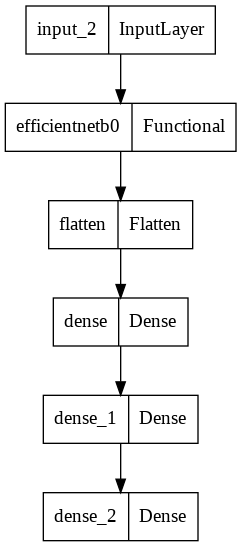

In [12]:
#모델 설계 구조 
import tensorflow 
tensorflow.keras.utils.plot_model(model)

In [13]:
#학습 방식은 동일 
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 10)                627210    
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 25)                275       
                                                                 
Total params: 4,677,166
Trainable params: 627,595
Non-trainab

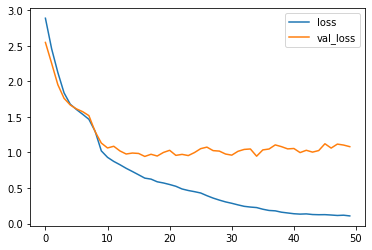

loss =  0.10682936757802963 , val_loss =  1.0814069509506226
14/14 [==============================] - 4s 311ms/step - loss: 0.1068 - accuracy: 0.9627 - val_loss: 1.0814 - val_accuracy: 0.8058


In [14]:
history = model.fit(train_x,train_y, epochs=50, verbose=1, batch_size=256, validation_split=0.2,callbacks=callbacks)

## y값 = crop만 
- efficientmap 동일 

In [22]:
crops = np.array(crops)

In [ ]:
crops[crops==1]=0
crops[crops==2]=1
crops[crops==3]=2
crops[crops==4]=3
crops[crops==5]=4
crops[crops==6]=5

In [31]:
set(crops)

{0, 1, 2, 3, 4, 5}

In [32]:
from sklearn.model_selection import train_test_split 
train_x, test_x, train_y, test_y = train_test_split(imgs,crops)

In [56]:
# conv_layers = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# conv_layers.trainable = False

conv_layers = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [58]:
image_input = Input((224,224,3))
x = conv_layers(image_input)
x = Flatten()(x)
x = Dense(10, activation = 'relu')(x)
x = Dense(10, activation = 'relu')(x)
output = Dense(6,activation = 'softmax')(x)
model_crop = Model(image_input,output)

In [59]:
#학습 방식은 동일 
model_crop.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ['accuracy'])
model_crop.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_15 (Dense)            (None, 10)                1003530   
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 6)                 66        
                                                                 
Total params: 24,591,418
Trainable params: 1,003,706
Non-tr

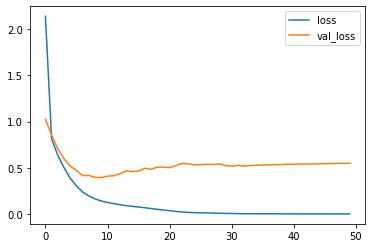

loss =  0.00113203888759017 , val_loss =  0.5489190220832825
14/14 [==============================] - 6s 437ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.5489 - val_accuracy: 0.8867


In [60]:
history = model_crop.fit(train_x,train_y, epochs=50, verbose=1, batch_size=256, validation_split=0.2,callbacks=callbacks)

In [44]:
y_ = model_crop.predict(test_x)

In [47]:
predicted = np.argmax(y_,axis=1)

In [50]:
error = test_y - predicted

In [55]:
len(error[error==0])/len(error)

0.9611650485436893

레스넷

In [61]:
y_ = model_crop.predict(test_x)
predicted = np.argmax(y_,axis=1)
error = test_y - predicted
print(len(error[error==0])/len(error))

0.891123439667129


### phase 2 disease 예측 
- image, crop, env를 이용 해서 disease 예측 

env 데이터 전처리

In [63]:
import csv

In [81]:
import csv
temp = []
f = open(train_csv[i], 'r', encoding='utf-8')
rdr = csv.reader(f)
for line in rdr:
    temp.append(line)

In [ ]:
train_csv = sorted(glob('train/*/*.csv'))

crops = []
diseases = []
risks = []
labels = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
    
        crops.append(crop)
        diseases.append(disease)
        risks.append(risk)
        labels.append(label)
        
label_unique = sorted(np.unique(labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

labels = [label_unique[k] for k in labels]
